The current notebook contains a Tumor Microenvironment comprehensive analysis pipeline.

1. It begins with the retrieval of gene expression data in CEL file format from GEO, which is then processed and transformed into a tabular format with sample IDs in rows and gene IDs in columns. This step may be skipped if you are not obtaining data from GEO.

2. The data preparation is followed by the Quality Check (QC), which is essential for ensuring the integrity and reliability of the data. This step involves checking for batch effects,outliers, and assessing the distribution of gene expression data to determine the quality of the dataset.

3. Next, the Tumor Microenvironment (TME) classification section is using the processed gene expression data from TCGA. During this step each sample is classified into one of the TME subtypes.

4. We also have an additional section which is de novo clusterisation. It is an optional step recommended for experienced users only. This section involves the formation of a reference *signatures* cohort based on a reference *gene expression* cohort provided by the user. The resulting cohort can then be used in place of the default TCGA cohort in the TME classification section. However, it is advised to use the default cohort to ensure accurate and unbiased results during classification.

# Import of python base packages

If you have opened the current file in view-only mode but want to use the code, please go back to our repositories Setup section and follow the [instructions](https://github.com/BostonGene/MFP). 

In [1]:
%load_ext autoreload
%matplotlib inline
%config IPCompleter.use_jedi = False

import os
import pandas as pd
import numpy as np
import seaborn as sns
import pathlib
import subprocess
import logging
import csv
import matplotlib.pyplot as plt
import umap
import matplotlib.pyplot as plt
from IPython.display import SVG
from tqdm import tqdm_notebook

%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from portraits.plotting import *
from portraits.mapping import get_gs_for_probes_from_3col,get_expressions_for_gs
from portraits.utils import read_gene_sets, ssgsea_formula, median_scale
from portraits.classification import KNeighborsClusterClassifier
from portraits.clustering import clustering_profile_metrics, clustering_profile_metrics_plot,clustering_select_best_tr

In [4]:
%load_ext rpy2.ipython

In [80]:
#Constants

EXPRESSION_MATRIX = 'Test/expressions.tsv'
TCGA_SIGNATURES = 'Cohorts/Pan_TCGA/signatures.tsv'
TCGA_COHORTS_ANNOTATION = 'Cohorts/Pan_TCGA/annotation.tsv'
CLASSIFIED_SAMPLES = 'classified_samples.tsv'
GENE_SIGNATURES = 'signatures/gene_signatures.gmt'
SUBTYPE_FINAL_CLUSTERS = 'samples_subtyping_by_tme.tsv'

# Example Data preparation

Example will be shown on Ulloa-Montoya GSE35640, GPL570 sample

## Get the example data from GEO

In [6]:
# Initialize and create a temporary directory for the CEL files

GSE = 'GSE35640'
PLATFORM = 'GPL570'
current_dir = pathlib.Path().parent.absolute()
dir_to_process = str(current_dir / 'TMPDIR')

In [7]:
if not os.path.exists(dir_to_process):
     os.mkdir(dir_to_process)

In [8]:
with open(os.devnull, "w") as f:
    subprocess.run([
        'wget',
        f'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE35nnn/{GSE}/suppl/{GSE}_RAW.tar'
    ],stdout=f, stderr=subprocess.STDOUT );

In [9]:
subprocess.run([
    'tar',
    '-xf',
    f'{GSE}_RAW.tar',
    '-C', dir_to_process
])
subprocess.run([
    'rm',
    f'{GSE}_RAW.tar'
])

CompletedProcess(args=['rm', 'GSE35640_RAW.tar'], returncode=0)

In [10]:
os.listdir(dir_to_process)

['GSM872328_MAGE008_sample_1.CEL.gz',
 'GSM872329_MAGE008_sample_2.CEL.gz',
 'GSM872330_MAGE008_sample_3.CEL.gz',
 'GSM872331_MAGE008_sample_4.CEL.gz',
 'GSM872332_MAGE008_sample_5.CEL.gz',
 'GSM872333_MAGE008_sample_6.CEL.gz',
 'GSM872334_MAGE008_sample_7.CEL.gz',
 'GSM872335_MAGE008_sample_8.CEL.gz',
 'GSM872336_MAGE008_sample_9.CEL.gz',
 'GSM872337_MAGE008_sample_10.CEL.gz',
 'GSM872338_MAGE008_sample_11.CEL.gz',
 'GSM872339_MAGE008_sample_12.CEL.gz',
 'GSM872340_MAGE008_sample_13.CEL.gz',
 'GSM872341_MAGE008_sample_14.CEL.gz',
 'GSM872342_MAGE008_sample_15.CEL.gz',
 'GSM872343_MAGE008_sample_16.CEL.gz',
 'GSM872344_MAGE008_sample_17.CEL.gz',
 'GSM872345_MAGE008_sample_18.CEL.gz',
 'GSM872346_MAGE008_sample_19.CEL.gz',
 'GSM872347_MAGE008_sample_20.CEL.gz',
 'GSM872348_MAGE008_sample_21.CEL.gz',
 'GSM872349_MAGE008_sample_22.CEL.gz',
 'GSM872350_MAGE008_sample_23.CEL.gz',
 'GSM872351_MAGE008_sample_24.CEL.gz',
 'GSM872352_MAGE008_sample_25.CEL.gz',
 'GSM872353_MAGE008_sample_26.CEL.

## Extracting expression values from CEL file

For affy arrays without special probes, use RMA
For GPL570/GPL96, use gcrma

In [11]:
%%R

# Load required R packages
library(affy)
library(annotate)
library(gcrma)

R[write to console]: Loading required package: BiocGenerics

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


R[write to console]: Loading required package: Biobase

R[write to console]: Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


R[write to console]

In [12]:
%%R -i dir_to_process -o normalized_expression

# Bulk read cell files
raw_expression <- ReadAffy(celfile.path = dir_to_process)

# Normalize expression using RMA
rma_normalized <- gcrma(raw_expression)

# Retrieve expressions from dataset
normalized_expression <- as.data.frame(exprs(rma_normalized))

R[write to console]: 



Adjusting for optical effect.................................................................Done.
Computing affinities.Done.
Adjusting for non-specific binding.................................................................Done.
Normalizing
Calculating Expression


In [13]:
normalized_expression.head()

,GSM872328_MAGE008_sample_1.CEL.gz,GSM872329_MAGE008_sample_2.CEL.gz,GSM872330_MAGE008_sample_3.CEL.gz,GSM872331_MAGE008_sample_4.CEL.gz,GSM872332_MAGE008_sample_5.CEL.gz,GSM872333_MAGE008_sample_6.CEL.gz,GSM872334_MAGE008_sample_7.CEL.gz,GSM872335_MAGE008_sample_8.CEL.gz,GSM872336_MAGE008_sample_9.CEL.gz,GSM872337_MAGE008_sample_10.CEL.gz,...,GSM872383_MAGE008_sample_56.CEL.gz,GSM872384_MAGE008_sample_57.CEL.gz,GSM872385_MAGE008_sample_58.CEL.gz,GSM872386_MAGE008_sample_59.CEL.gz,GSM872387_MAGE008_sample_60.CEL.gz,GSM872388_MAGE008_sample_61.CEL.gz,GSM872389_MAGE008_sample_62.CEL.gz,GSM872390_MAGE008_sample_63.CEL.gz,GSM872391_MAGE008_sample_64.CEL.gz,GSM872392_MAGE008_sample_65.CEL.gz
1007_s_at,9.816090,6.474644,9.113994,7.044742,8.719946,4.852191,7.190953,8.636192,5.623183,7.433451,...,6.287400,7.017124,7.533525,7.042195,8.809050,8.198514,8.457781,7.530108,4.724734,9.222943
1053_at,5.664499,6.540040,5.569006,5.745150,4.690936,5.923728,5.700713,5.120923,5.394368,6.704893,...,5.992869,6.754348,5.943736,6.333925,6.063615,6.360003,6.073347,7.141974,7.191548,5.611221
117_at,8.394219,6.083483,6.587381,6.092671,3.411626,3.791668,5.667734,4.965991,4.475886,4.443469,...,3.296701,5.638913,3.205921,3.471334,3.682211,8.971476,4.343425,5.738228,4.807307,10.331267
121_at,2.390202,2.345001,2.390202,2.388071,2.390202,2.390202,2.454035,2.390202,3.128954,2.390202,...,2.320004,2.390202,2.411101,2.390202,2.390202,2.390202,2.380696,2.390202,2.882576,2.434246
1255_g_at,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,...,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.348901,2.223272,2.223272,2.223272


In [14]:
# Trim names to make the table more readable.

normalized_expression.columns = normalized_expression.columns.to_series().apply(lambda x: x.split('_')[0]).values
normalized_expression.head()

,GSM872328,GSM872329,GSM872330,GSM872331,GSM872332,GSM872333,GSM872334,GSM872335,GSM872336,GSM872337,...,GSM872383,GSM872384,GSM872385,GSM872386,GSM872387,GSM872388,GSM872389,GSM872390,GSM872391,GSM872392
1007_s_at,9.816090,6.474644,9.113994,7.044742,8.719946,4.852191,7.190953,8.636192,5.623183,7.433451,...,6.287400,7.017124,7.533525,7.042195,8.809050,8.198514,8.457781,7.530108,4.724734,9.222943
1053_at,5.664499,6.540040,5.569006,5.745150,4.690936,5.923728,5.700713,5.120923,5.394368,6.704893,...,5.992869,6.754348,5.943736,6.333925,6.063615,6.360003,6.073347,7.141974,7.191548,5.611221
117_at,8.394219,6.083483,6.587381,6.092671,3.411626,3.791668,5.667734,4.965991,4.475886,4.443469,...,3.296701,5.638913,3.205921,3.471334,3.682211,8.971476,4.343425,5.738228,4.807307,10.331267
121_at,2.390202,2.345001,2.390202,2.388071,2.390202,2.390202,2.454035,2.390202,3.128954,2.390202,...,2.320004,2.390202,2.411101,2.390202,2.390202,2.390202,2.380696,2.390202,2.882576,2.434246
1255_g_at,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,...,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.348901,2.223272,2.223272,2.223272


In [15]:
# delete unnecessary files

subprocess.run(['rm',  '-r','TMPDIR/'])

CompletedProcess(args=['rm', '-r', 'TMPDIR/'], returncode=0)

## Converting probe ids to HUGO gene symbols

Get a chip SOFT file and turn it into a 3-column file.<br>

1st column: probe id<br>
2nd column: gene symbol column (as is with '///')<br>
3rd column: entrez id (not needed for the study)

To download the SOFT file manually, follow these steps (we use the Ulloya-Montoya sample as an example):

* Go to https://www.ncbi.nlm.nih.gov/geo/
* Type the GLP platform number – GLP570 – in the search bar
* Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GPL570
* Find the Annotation SOFT table at the bottom of the page
* Click the button to download the SOFT annotation table for your sample (GPL570.annot.gz in our example)
* Upload the file to the environment.

To download SOFT annotation table from jupyter notebook, change the PLATFORM value to appropriate GPL platform


In [16]:
with open(os.devnull, "w") as f:
    subprocess.run([
        'wget',
        f'ftp://ftp.ncbi.nlm.nih.gov/geo/platforms/GPLnnn/{PLATFORM}/annot/{PLATFORM}.annot.gz'
    ], stdout=f, stderr=subprocess.STDOUT)

Once you’ve downloaded the SOFT file, extract the data from it. Unzip the SOFT file to get GPL570.annot.gz

In [17]:
subprocess.run(['gunzip', f'{PLATFORM}.annot.gz'])

CompletedProcess(args=['gunzip', 'GPL570.annot.gz'], returncode=0)

Remove the header from the SOFT file to avoid any problems in further processes

In [18]:
subprocess.run("sed '1,/^ID/d' GPL570.annot > GPL570.beheaded.annot", shell = True)

CompletedProcess(args="sed '1,/^ID/d' GPL570.annot > GPL570.beheaded.annot", returncode=0)

Subsetting SOFT file to have 3 columns 

In [19]:
gene_SOFT_annotations = pd.read_csv(f'{PLATFORM}.beheaded.annot', sep = '\t', header = None)
gene_SOFT_annotations = gene_SOFT_annotations.iloc[:, [0, 2, 3]]

# Rename columns
gene_SOFT_annotations = gene_SOFT_annotations.rename(columns = {2: 1, 3 : 2})
gene_SOFT_annotations.to_csv(f'{PLATFORM}.3col', sep = '\t',  index=False, quoting=csv.QUOTE_NONNUMERIC)

In [20]:
gene_SOFT_annotations.head()

,0,1,2
0,1007_s_at,MIR4640///DDR1,100616237///780
1,1053_at,RFC2,5982
2,117_at,HSPA6,3310
3,121_at,PAX8,7849
4,1255_g_at,GUCA1A,2978


Delete all unnecessary files

In [21]:
subprocess.run(['rm', f'{PLATFORM}.annot'])
subprocess.run(['rm', f'{PLATFORM}.beheaded.annot'])

CompletedProcess(args=['rm', 'GPL570.beheaded.annot'], returncode=0)

In [22]:
probes_gs_dict = get_gs_for_probes_from_3col(f'{PLATFORM}.3col', normalized_expression.index.tolist())

In [23]:
pd.Series(probes_gs_dict).head(10)

1007_s_at    [MIR4640, DDR1]
1053_at               [RFC2]
117_at               [HSPA6]
121_at                [PAX8]
1255_g_at           [GUCA1A]
1294_at      [MIR5193, UBA7]
1316_at               [THRA]
1320_at             [PTPN21]
1405_i_at             [CCL5]
1431_at             [CYP2E1]
dtype: object

In [24]:
series = pd.Series(probes_gs_dict)
annotated_expression = get_expressions_for_gs(series, normalized_expression, 'max').T.sort_index()

annotated_expression.to_csv(EXPRESSION_MATRIX, sep='\t', index=True)

# Quality check (QC)

In [25]:
annotated_expression = pd.read_csv(EXPRESSION_MATRIX, sep='\t', index_col=0)

The Quality Check (QC) section identifies batches, outliers, and assesses the expression data distribution.

We will provide examples of both bad and good datasets, which will help you differentiate them visually and understand the types of possible data quality issues that may affect downstream analyses.

## Batch detection

This section is responsible for identifying any potential batch effects in the analyzed data using UMAP and PCA analyses. The results of these analyses are plotted to visualize any potential batches in the data.

If you are not familiar with batch effects follow [this link](https://towardsdatascience.com/batcheffectsc71c886ca9c5)

### Batche detection by UMAP

![Umap Example](plots/umap_examples.svg)

Above is an example of a sample check results for the presence of batch effects using the UMAP analysis. Two plots have been generated to visualize possible analysis results. The plot on the right shows an example of a dataset with no identified issues, whereas the plot on the left exhibits potential batch effects.

You can see that the plot on the right shows two distinct clusters of data points that are grouped quite far from each other. This is indicative of the presence of a potential batch effect.

If your data plot resembles the one on the right, remove any identified batch effects to ensure accurate and reliable results.

[Here are the instructions for batch effect removal](https://github.com/chichaumiau/removeBatcheffect)

<AxesSubplot:>

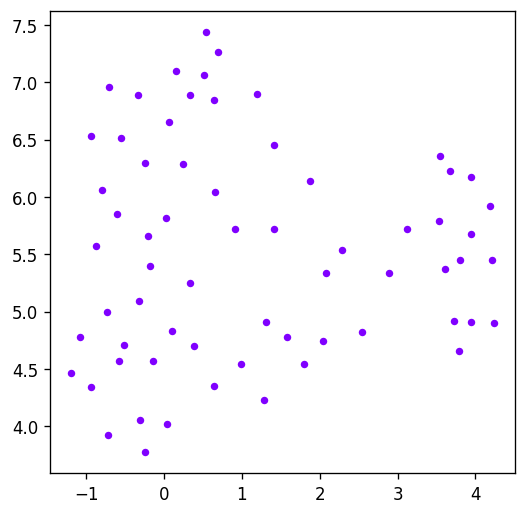

In [26]:
# Generate umap_plot for the input data
umap_plot(annotated_expression.T, legend = 'Out')

### Batch detection by PCA

To further enhance the significance of our analysis, we additionally perform the PCA analysis and plot the results to ensure that our data is free from any batch effects.

Below is an example of a sample check results for the presence of batch effects using the PSA analysis. Again, two plots have been generated to visualize possible analysis results.  Batch effects in the plot on the left can be suggested from the presence of s two distinct groups of data points that appear far from each other. In contrast, a normal dataset appears as a single group of data points that are relatively close to each other, as reflected in the PCA plot.

This step is essential to ensure that (a) the data used is free from any systematic variation that could confound the analyses and (b) any observed effects are biologically meaningful.

![Pca batches example not colored](plots/pca_batches_example_colored.svg)

<AxesSubplot:xlabel='PCA 1 component 14% variance explained', ylabel='PCA 2 component 10% variance explained'>

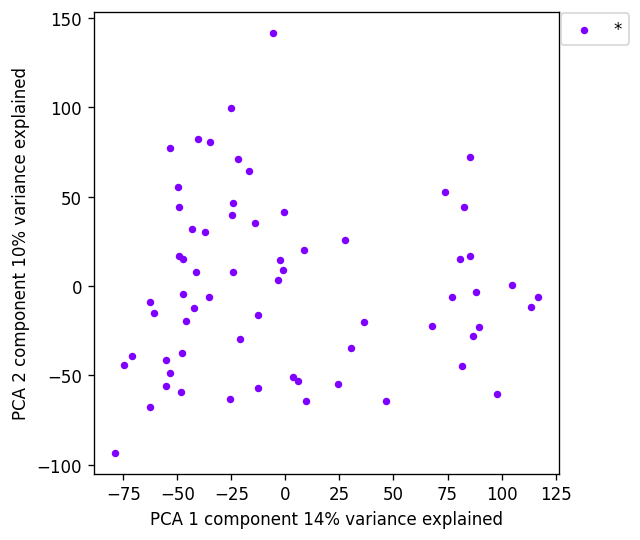

In [27]:
# Generate the pca plot for the annotated_expressions
pca_plot(annotated_expression.T, legend = 'out')

## Outlier detection

The purpose of this section is to identify outliers in the annotated_expression data through PCA analysis and the generation of corresponding plots.

The code cell below generates a PCA plot of the transposed annotated_expression data. Transposing the data allows the sample IDs to be located in the row positions, which facilitates dimension reduction based on samples. This plot can help identify any possible data outliers.

Below is an illustrative example of data outliers.
In the plot on the left, two points lie far away from the main group of data points, indicating the presence of outliers in the dataset. In contrast, the data points in the plot on the right lie relatively close to each other, with no outliers detected.

To get detailed information on data outliers, follow this [link](https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/)

![PCA outliers example](plots/pca_outliers_example.svg)

<AxesSubplot:xlabel='PCA 1 component 14% variance explained', ylabel='PCA 2 component 10% variance explained'>

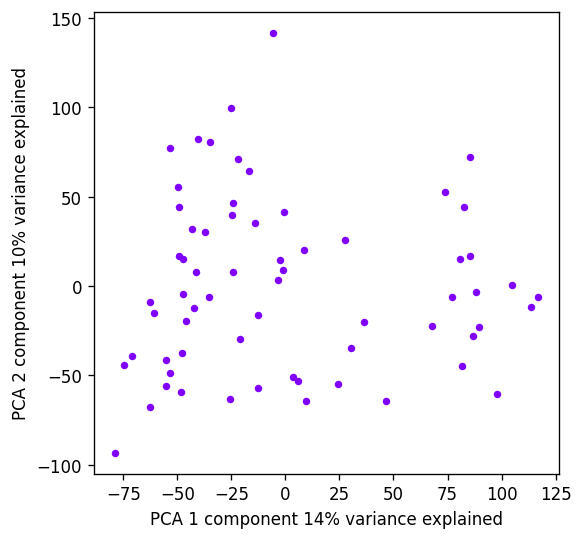

In [28]:
# Generate pca plot for annotated_expression to find outliers
pca_plot(annotated_expression.T, legend= None)

If the pca_plot of your data suggests the analyzed data contain outliers, remove the outlying points from your dataset.

In [29]:
# Check for repetitive values 
annotated_expression.columns.value_counts().max()

1

## Data distribution check

Data distribution check

This is the final section of the QC, where data quality is checked based on its distribution.

As with the previous sections, an example of two gene expression datasets is provided below, with one exhibiting a good-quality dataset and the other exhibiting a poor-quality dataset, as indicated by their respective distribution plots.

In the plot on the right, the expression values start off very low and then rise before dropping down. This pattern suggests potential RNA degradation, which can compromise the reliability and accuracy of downstream analyses. In contrast, the distribution plot on the left shows good-quality gene expression data.
Deviations from such distributions may indicate gene degradation, should be carefully investigated and, if necessary, corrected to ensure high-quality data.

If your data plot shows distribution of a good quality data, you can proceed with the analyses. If it resembles the one on the right, then your data is probably abnormal and might have RNA degradation. In the case of RNA degradation,  do not proceed with the analyses and choose a new dataset.

![Data distribution example](plots/distribution_example.svg)

The code snippet provided generates a visualization of the distribution of annotated expression values. This type of data visualization is useful for identifying trends and patterns in gene expression data and can aid in the quality control and preprocessing of the data.

<AxesSubplot:ylabel='Density'>

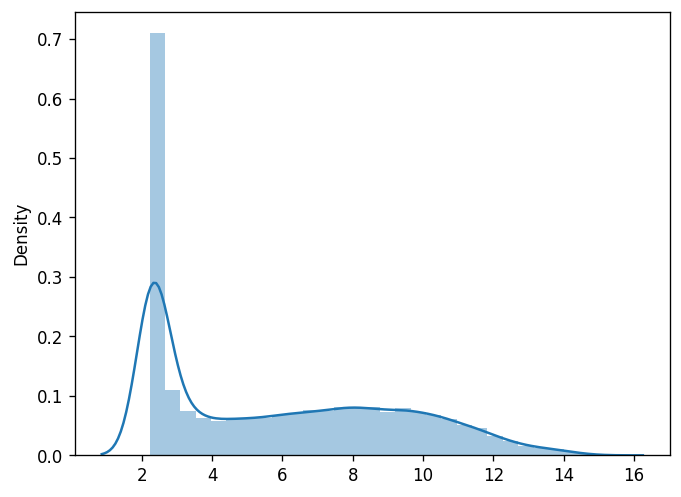

In [30]:
sns.distplot(annotated_expression.mean(axis=1), kde = True)

If you have successfully passed all of the QC tests, you can move to the TME classification step. If there are any data issues, fix them before proceeding to the next step as they can affect the results of the analyses.

In [31]:
#Printing the dataframe to know how it looks in table form 
annotated_expression.head()

,GSM872328,GSM872329,GSM872330,GSM872331,GSM872332,GSM872333,GSM872334,GSM872335,GSM872336,GSM872337,...,GSM872383,GSM872384,GSM872385,GSM872386,GSM872387,GSM872388,GSM872389,GSM872390,GSM872391,GSM872392
A1BG,3.078552,2.987851,2.987851,3.165811,2.728912,3.655134,2.987851,2.987851,3.576304,6.004672,...,4.336052,3.016967,2.987851,3.565415,3.567615,2.987851,2.987851,2.899146,3.058037,2.987851
A1BG-AS1,5.749913,4.904272,4.388127,4.360712,4.244502,4.356337,4.494508,4.478265,4.595821,5.300090,...,4.310518,4.597341,4.636256,4.597341,4.606501,4.597341,4.597341,4.639346,4.412341,4.742684
A1CF,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,...,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272,2.223272
A2M,11.726740,11.031260,11.897860,10.843689,12.949128,12.603719,13.162092,11.998046,12.926885,12.836179,...,12.034147,12.973168,12.724960,10.293074,13.931410,13.758179,12.476536,10.576425,12.909873,12.791583
A2M-AS1,6.443771,6.102404,6.606300,5.389406,7.313690,7.771913,7.293835,6.468055,7.778143,7.140280,...,8.238855,7.263452,7.986488,4.551769,8.104151,8.618934,6.642779,5.118838,7.025310,8.441181


# TME classification

The classification section determines each sample subtype against the TCGA cohort. The TCGA cohort was split into clusters using KNeighborsClusterClassifier. The resulting clusters are stored as a MODEL variable, with each cluster belonging to a different subtype. Then the samples expressions.tsv and signatures.gmt files are read and passed to the ssgsea_formula function to determine each signature (columns) score for every sample (rows).

## Load Reference Cohort with known TME labels and gene expression values


Load the TCGA cohort

In [32]:
TCGA_signature_scores_scaled = pd.read_csv(TCGA_SIGNATURES, sep='\t', index_col=0).T  # Signatures in rows
print(f'Reference signatures provided for {len(TCGA_signature_scores_scaled)} samples')

TCGA_annotation = pd.read_csv(TCGA_COHORTS_ANNOTATION, sep='\t', index_col=0)  # Contains MFP cluster labels in MFP column
print(f'Reference annotation provided for {len(TCGA_signature_scores_scaled)} samples')

In [32]:
# Fit the model
MODEL = KNeighborsClusterClassifier(norm=False, scale=False, clip=2, k=35).fit(TCGA_signature_scores_scaled,
                                                                               TCGA_annotation.MFP)

# Read signatures
gene_signatures = read_gene_sets(GENE_SIGNATURES)  # GMT format like in MSIGdb
print(f'Loaded {len(gene_signatures)} signatures')

# Read expressions
gene_expressions = pd.read_csv(EXPRESSION_MATRIX, sep='\t', index_col=0)  # log2+1 transformed; Genes should appear to be in rows

print(f'Classifying cohort, N={len(gene_expressions)} samples')

if gene_expressions.max().max() > 35:
    print('Performing log2+1 transformation')
    gene_expressions = np.log2(1+gene_expressions)
    

Reference signatures provided for 8024 samples
Reference annotation provided for 8024 samples
Loaded 29 signatures
Classifying cohort, N=22836 samples


The codeblock below establishes to which subtype each sample belongs and then prints out the number of samples that have the given subtype. The classified_sample.tsv file is given as an output. It lists the subtypes of all analyzed samples.


## Classify the input cohort and give the output .tsv file with the TME subtype for each sample

In [33]:
# Calc signature scores
signature_scores = ssgsea_formula(gene_expressions, gene_signatures)

# Scale signatures
signature_scores_scaled = median_scale(signature_scores)

In [34]:
# Predict clusters
classified_samples = MODEL.predict(signature_scores_scaled[MODEL.X.columns]).rename('TME')

#Output the predicted clusters
print('Predicted labels count:')
print(classified_samples.value_counts())

# Output the classified samples table
classified_samples.to_csv(CLASSIFIED_SAMPLES, sep='\t', index=True)

Predicted labels count:
D       31
IE      18
IE/F     8
F        8
Name: TME, dtype: int64


### Visalize classified data

The code provided below generates several plots to make the data visualisation easier and to help you understand the differences betweeen signatures.

In [35]:
classified_samples = pd.read_csv(CLASSIFIED_SAMPLES, sep='\t', index_col=0)

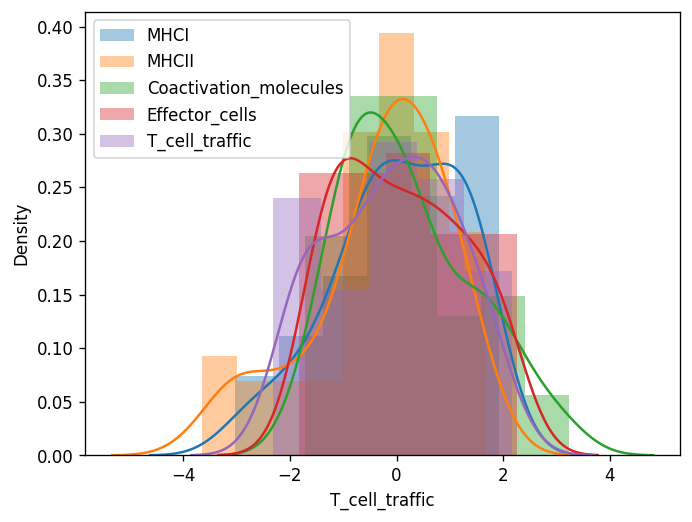

In [36]:
# generating distribution plots for already scaled signature values

fig, ax = plt.subplots(1, 1)
for i in signature_scores_scaled.columns[:5]:
    sns.distplot(signature_scores_scaled[i], label=i, ax=ax, kde=True)
ax.legend()

<AxesSubplot:xlabel='TME'>

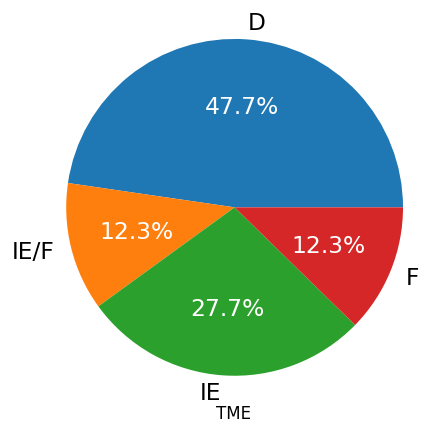

In [37]:
# classified_samples = pd.Series(classified_samples)
vector_pie_plot(classified_samples.squeeze())

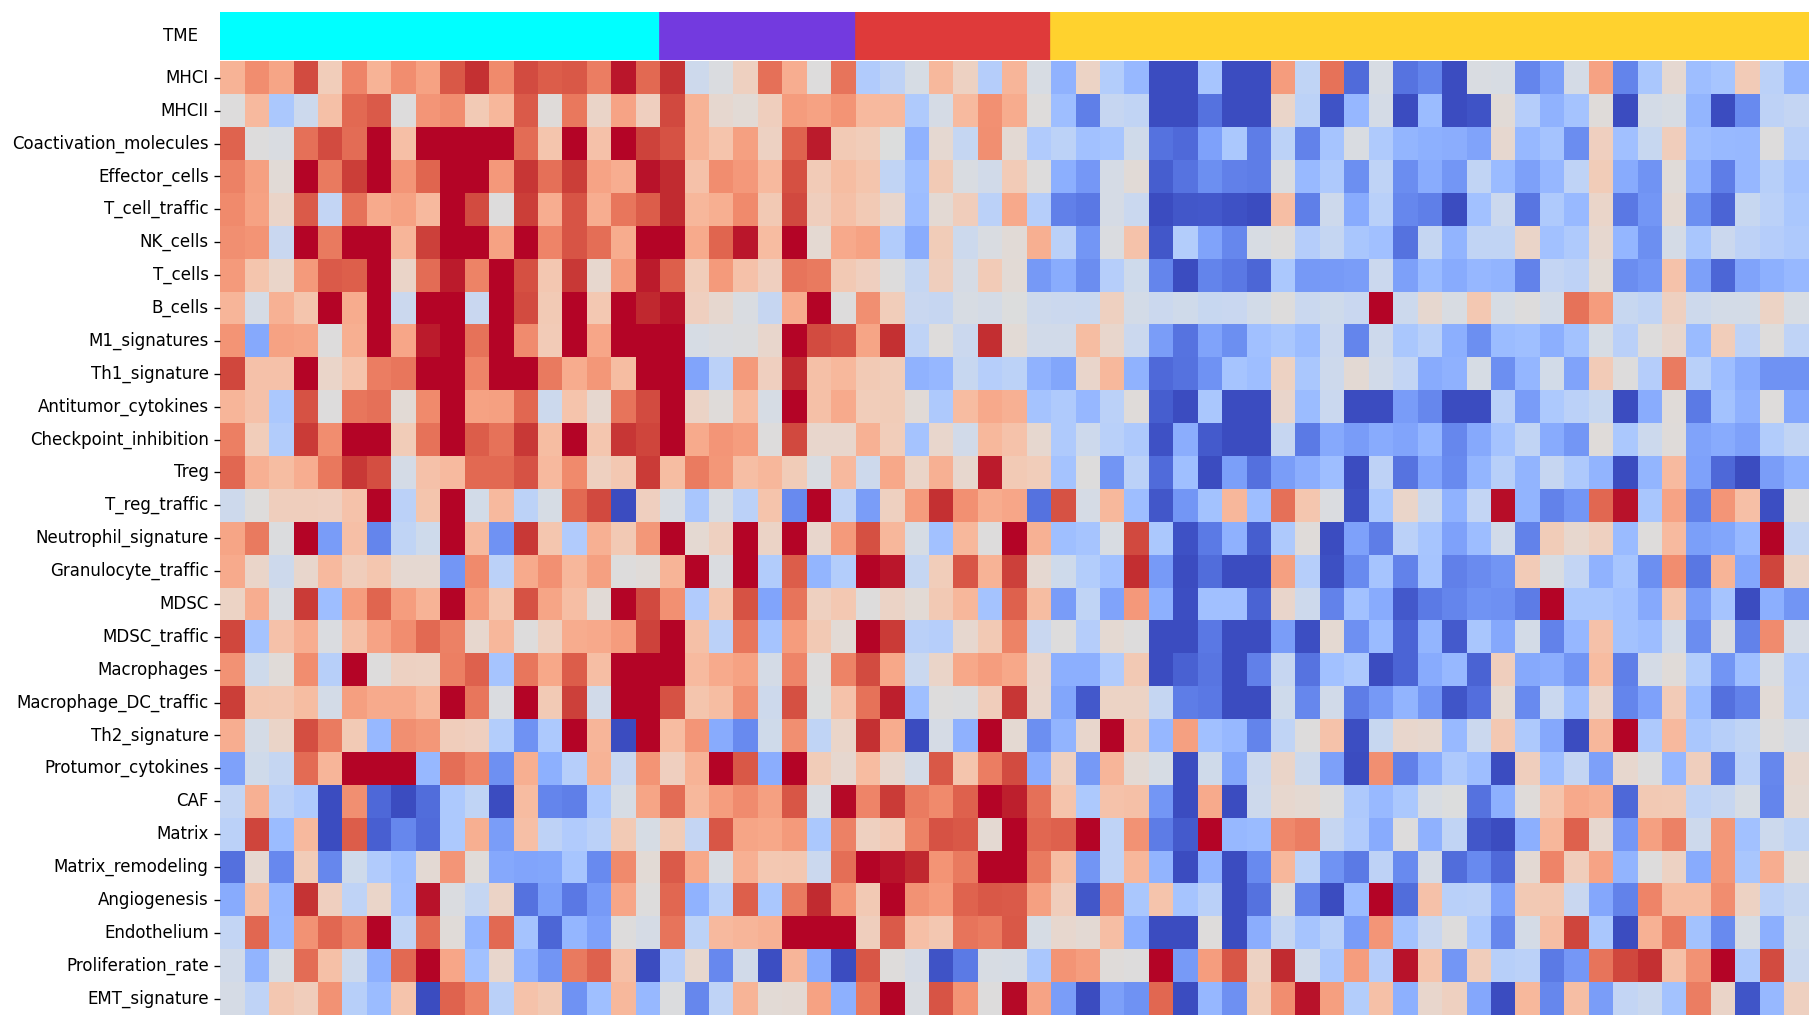

In [55]:
af = axis_matras([.4, 8], x_len=15)
ax=next(af)

tme_pallete = {"IE": '#00ffff', "IE/F": '#733adf', "F": '#df3a3a', "D": '#ffd22e'}

order = ["IE","IE/F","F", "D"]

ordered_classified_samples = pd.read_csv(CLASSIFIED_SAMPLES, sep='\t')

ordered_classified_samples['TME'] = pd.Categorical(ordered_classified_samples['TME'], categories=order, ordered=True)

ordered_classified_samples = ordered_classified_samples.sort_values('TME')

classified_samples = pd.Series(classified_samples.squeeze())

line_palette_annotation_plot(classified_samples[ordered_classified_samples.iloc[:,0]], ax=ax, palette=tme_pallete)

ax = next(af)
sns.heatmap(signature_scores_scaled.loc[ ordered_classified_samples.iloc[:,0],gene_signatures].clip(-2, 2).T,
            yticklabels=True, xticklabels=False, cbar=False, cmap=plt.cm.coolwarm)
plt.tight_layout(pad=.1)


# de novo clusterization

## Calculate signature scores of reference gene expression values

In [82]:
# Example script

# Read signatures
gmt = read_gene_sets(GENE_SIGNATURES)  # GMT format like in MSIGdb


# Read expressions
exp = pd.read_csv(EXPRESSION_MATRIX, sep='\t', index_col = 0)  # log2+1 transformed; Genes in columns

# Calc signature scores
signature_scores = ssgsea_formula(exp, gmt)

# Scale signatures
signature_scores_scaled = median_scale(signature_scores)

signature_scores_scaled.head()



,MHCI,MHCII,Coactivation_molecules,Effector_cells,T_cell_traffic,NK_cells,T_cells,B_cells,M1_signatures,Th1_signature,...,Macrophage_DC_traffic,Th2_signature,Protumor_cytokines,CAF,Matrix,Matrix_remodeling,Angiogenesis,Endothelium,Proliferation_rate,EMT_signature
GSM872328,1.343932,-1.927966,-0.709875,-0.624693,-0.223812,-0.336393,-1.245419,-0.217499,-0.253581,-0.228317,...,-0.187442,0.519710,-1.172032,0.000000,-0.316514,-1.326077,-2.399462,-0.497626,-0.671340,0.940784
GSM872329,-1.631422,-2.525349,-0.932813,-1.382324,-1.451595,-1.640942,-1.186805,-0.235935,-0.663517,-0.366576,...,-0.948353,0.181062,-1.507739,-0.649172,0.000000,-1.408041,-1.699175,-0.740179,1.942653,-0.986939
GSM872330,-1.475856,-0.841059,-0.996619,-1.044256,-1.520137,-0.329958,-0.859033,0.156090,-0.485315,-1.054475,...,-1.306083,0.140916,-1.032607,-0.087223,-0.969004,-0.109842,0.541437,-0.295640,0.501525,0.183189
GSM872331,-2.327941,-2.106570,-1.020332,-1.292678,-2.004865,-0.939926,-1.051379,-0.069391,-1.008595,-0.969880,...,-1.908347,-0.866855,-0.614442,-0.003902,-0.390023,-1.701606,-0.491603,0.012649,-1.286683,0.303761
GSM872332,0.000000,0.908612,1.908271,0.401430,0.331190,0.119207,1.286086,3.315214,1.645273,0.547043,...,-0.005509,-0.395391,0.387733,-0.050035,-0.653643,-0.261586,1.845939,2.865235,-1.060149,0.919687


## Visualize clusters according to the selected threshold and statistical scores of correlation between data values


The clusterization is done using the clustering_profile_metrics function from the clustering.py library. The calculations are done using Davies Bouldin, Calinski Harabasz, Silouhette scores to get the correlation between clusters and each ssGSEA score data point.

For more information on the mentioned calculations and correlation scores, follow [this link](https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c)

Check the clustering within a range of 30% to 65% similarity
- \>65% - means no correlation between data points in the graph
- <30% - means a false positive correlation

100%|██████████| 35/35 [00:01<00:00, 23.04it/s]


<AxesSubplot:ylabel='Cluster %'>

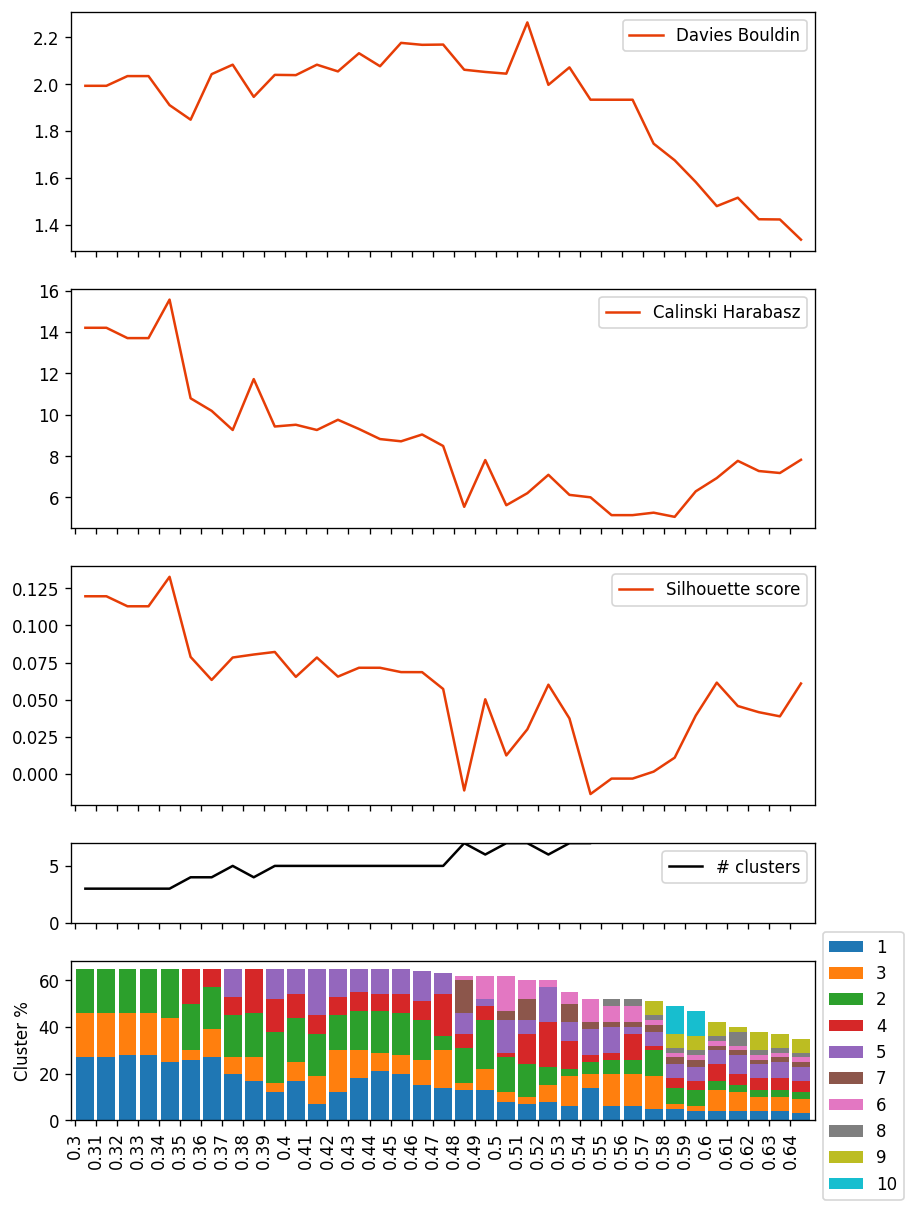

In [83]:
clustering_metrics = clustering_profile_metrics(signature_scores_scaled, threshold_mm=(.3, .65), step=.01)

# Visualize the partitions
clustering_profile_metrics_plot(clustering_metrics)

The plot above shows the count of clusters and their size for each threshold.

## Classify each cluster/sample into a TME subtype 

In [84]:
def detect_type(clustering_metrics: pd.DataFrame,scores: pd.DataFrame) -> pd.Series:

    clusters_number = clustering_metrics.loc['N'] 

    # samples_clustering is a pd.Series with patients as indexes and their clusters as values
    samples_clustering = clustering_metrics.loc['perc']
    cluster_means = pd.DataFrame({cluster: scores.loc[samples_clustering[samples_clustering == cluster].index].mean()
                                  for cluster in range(1, clusters_number + 1)})

    deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling']].mean() -
              cluster_means.loc[['MHCII', 'Antitumor_cytokines', 'Coactivation_molecules',
                          'B_cells', 'NK_cells', 'Checkpoint_inhibition',
                          'Effector_cells', 'T_cells', 'Th1_signature',
                          'T_cell_traffic', 'MHCI']].mean()).sort_values()

    mapper = {}
    mapper[deltas.index[-1]] = 'F'  # The cluster with the highest fibrose value is classified as Fibrotic
    mapper[deltas.index[0]] = 'IE'  # Thecluster with the highest level of immune cells is classified as 
                                    # Immune enriched, non-fibrotic

    # Remove detected clusters
    cluster_means.pop(deltas.index[-1])
    cluster_means.pop(deltas.index[0])

    deltas = (cluster_means.loc[['Angiogenesis', 'Endothelium', 'CAF', 'Matrix', 'Matrix_remodeling',
                          'Protumor_cytokines', 'Neutrophil_signature', 'Granulocyte_traffic',
                          'Macrophages', 'Macrophage_DC_traffic', 'MDSC_traffic', 'MDSC',
                          'Th2_signature', 'T_reg_traffic', 'Treg', 'M1_signatures', 'MHCII',
                          'Antitumor_cytokines', 'Coactivation_molecules', 'B_cells', 'NK_cells',
                          'Checkpoint_inhibition', 'Effector_cells', 'T_cells', 'Th1_signature',
                          'T_cell_traffic', 'MHCI', 'EMT_signature']].mean() -
              cluster_means.loc['Proliferation_rate']).sort_values()

    mapper[deltas.index[0]] = 'D'  # The cluster with the highest proliferation value 
                                   # is classified as (Immune) Desert

    mapper[deltas.index[-1]] = 'IE/F'  # Every sample not falling into the above-mentioned 
                                       # categories is classified as Immune enriched - fibrotic

    return samples_clustering.map(mapper).rename('MFP')

In [85]:
# Select the best threshold using one or more metrics
best_threshold = '0.31'

# Detect cluster types
samples_subtyping_by_tme = detect_type(clustering_metrics.loc[best_threshold], signature_scores_scaled)

# Output the data into console
print(samples_subtyping_by_tme)

# Output the clusters
samples_subtyping_by_tme.to_csv(SUBTYPE_FINAL_CLUSTERS, sep='\t', index=True)

GSM872328      IE
GSM872335       F
GSM872359      IE
GSM872378      IE
GSM872329    IE/F
             ... 
GSM872341       F
GSM872372       F
GSM872373       F
GSM872379      IE
GSM872349      IE
Name: MFP, Length: 65, dtype: object
